## ToDos:
1. Train-Test-Split
2. EDA
3. Impute missing values
4. BaseLine Model
5. Make Features and Target Stationary
6. Model 

In [1]:
# Import 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
sns.set()

In [2]:
def plot_time_series(dataframe, min_date, max_date, size):
    if type(dataframe) == pd.Series:
        f, ax = plt.subplots(nrows=1, ncols=1, figsize=size)
        sns.lineplot(x=dataframe.index, y=dataframe)
        ax.set_xlim([datetime.strptime(min_date, "%Y-%m-%d"), datetime.strptime(max_date, "%Y-%m-%d")])

    else:
        f, ax = plt.subplots(nrows=len(dataframe.columns), ncols=1, figsize=size)
        for element in enumerate(dataframe.columns):
            sns.lineplot(x=dataframe.index, y=dataframe[element[1]], ax=ax[element[0]])
            ax[element[0]].set_xlim([datetime.strptime(min_date, "%Y-%m-%d"), datetime.strptime(max_date, "%Y-%m-%d")])

    plt.show()

In [3]:
df = pd.read_csv("./data/Aquifer_Petrignano.csv", index_col=0, parse_dates=True, dayfirst=True)

In [4]:
print(df.columns)
columns = ['Rf_BU', 'DtG_P24', 'DtG_P25', 'T_BU', 'T_Pe', 'V_Pe', 'H_FCP']
df.columns = columns

Index(['Rainfall_Bastia_Umbra', 'Depth_to_Groundwater_P24',
       'Depth_to_Groundwater_P25', 'Temperature_Bastia_Umbra',
       'Temperature_Petrignano', 'Volume_C10_Petrignano',
       'Hydrometry_Fiume_Chiascio_Petrignano'],
      dtype='object')


In [197]:
df.head(1)

,Rf_BU,DtG_P24,DtG_P25,T_BU,T_Pe,V_Pe,H_FCP
Date,,,,,,,
2006-03-14,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN


In [198]:
df.count()

Rf_BU      4199
DtG_P24    5168
DtG_P25    5184
T_BU       4199
T_Pe       4199
V_Pe       5025
H_FCP      4199
dtype: int64

In [199]:
df.isna().sum()

Rf_BU      1024
DtG_P24      55
DtG_P25      39
T_BU       1024
T_Pe       1024
V_Pe        198
H_FCP      1024
dtype: int64

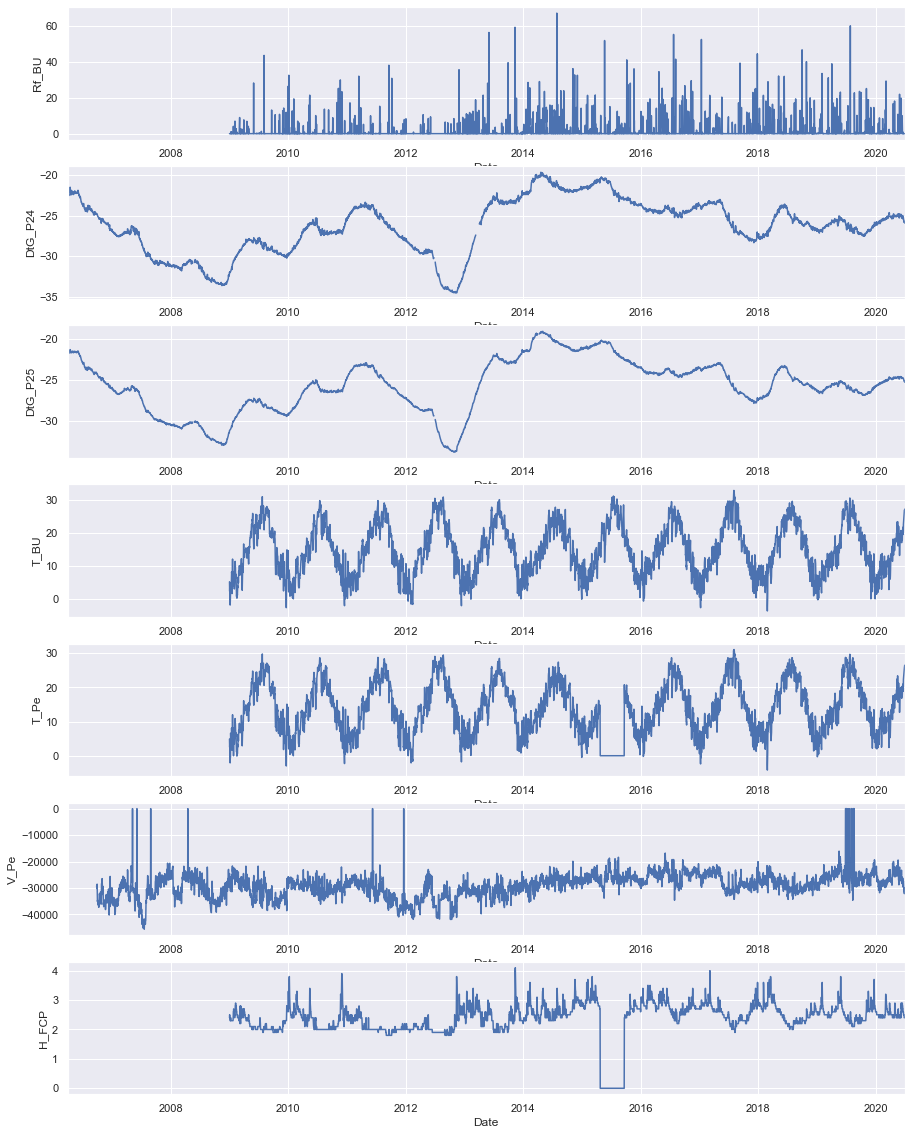

In [200]:
plot_time_series(df, '2006-04-01', '2020-06-30', (15, 20))

### Replace zero values of V_Pe, H_FCP, T_Pe with NaN

In [151]:
df_imputed = df.copy()

In [152]:
df_imputed['T_Pe'] = np.where(((df['T_Pe'] == 0) & (df['T_Pe'].shift(1) == 0)) | (df['T_Pe'].diff(-1) > 10) | ((df['T_Pe'] == 0) & (df['T_Pe'].shift(-1) == 0)), np.nan, df['T_Pe'])
df_imputed['V_Pe'] = np.where(df['V_Pe'] == 0, np.nan, df['V_Pe'])
df_imputed['H_FCP'] = np.where(df['H_FCP'] == 0, np.nan, df['H_FCP'])

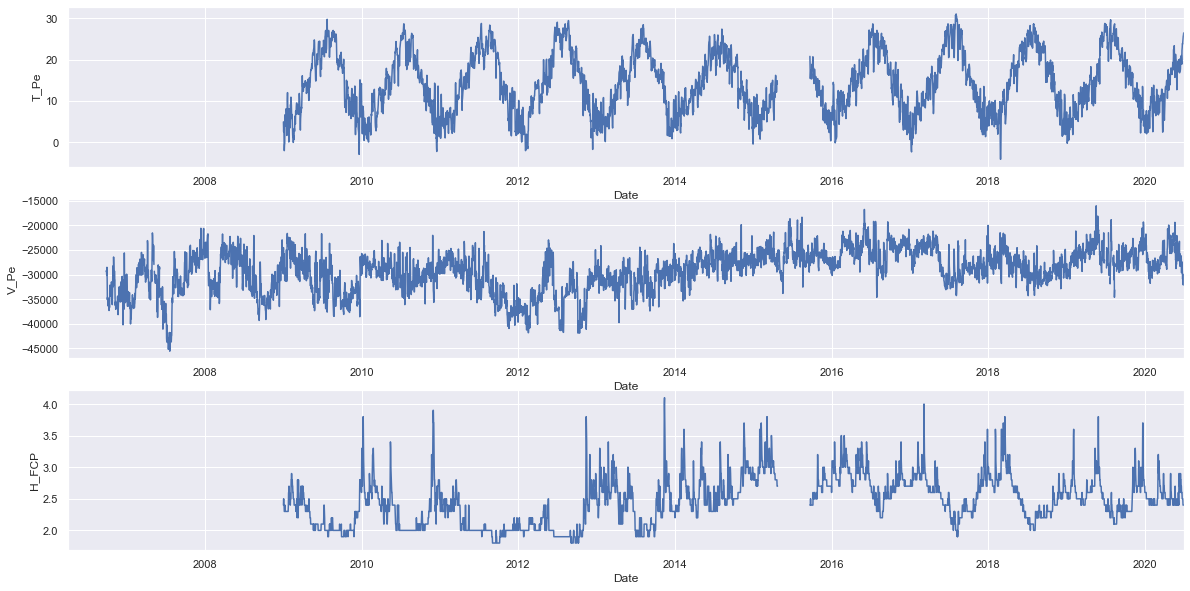

In [203]:
plot_time_series(df_imputed[['T_Pe', 'V_Pe', 'H_FCP']], '2006-04-01', '2020-06-30', (20,10))

### Replace NaN in dataset

#### T_Pe

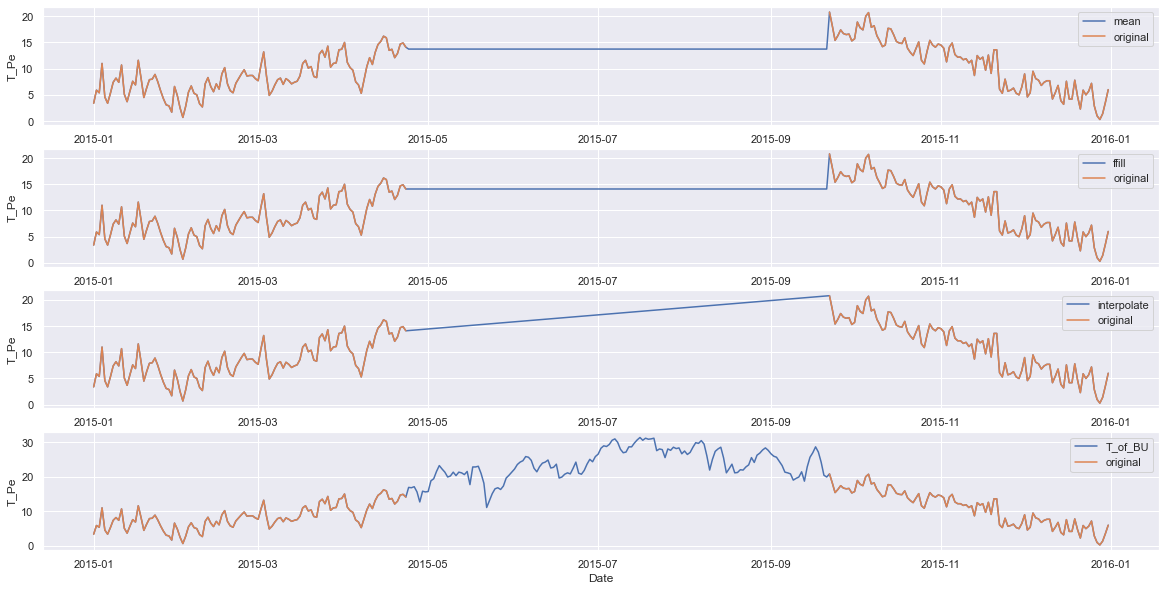

In [204]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(20,10))
subset = df_imputed.loc['2015']

sns.lineplot(x=subset.index, y=subset['T_Pe'].fillna(df['T_Pe'].mean()), label='mean', ax=ax[0])
sns.lineplot(x=subset.index, y=subset['T_Pe'], label='original', ax=ax[0])

sns.lineplot(x=subset.index, y=subset['T_Pe'].ffill(), label='ffill', ax=ax[1])
sns.lineplot(x=subset.index, y=subset['T_Pe'], label='original', ax=ax[1])

sns.lineplot(x=subset.index, y=subset['T_Pe'].interpolate(), label='interpolate', ax=ax[2])
sns.lineplot(x=subset.index, y=subset['T_Pe'], label='original', ax=ax[2])

sns.lineplot(x=subset.index, y=subset['T_Pe'].fillna(df['T_BU']), label='T_of_BU', ax=ax[3])
sns.lineplot(x=subset.index, y=subset['T_Pe'], label='original', ax=ax[3])

plt.legend()
plt.show()

#### V_Pe

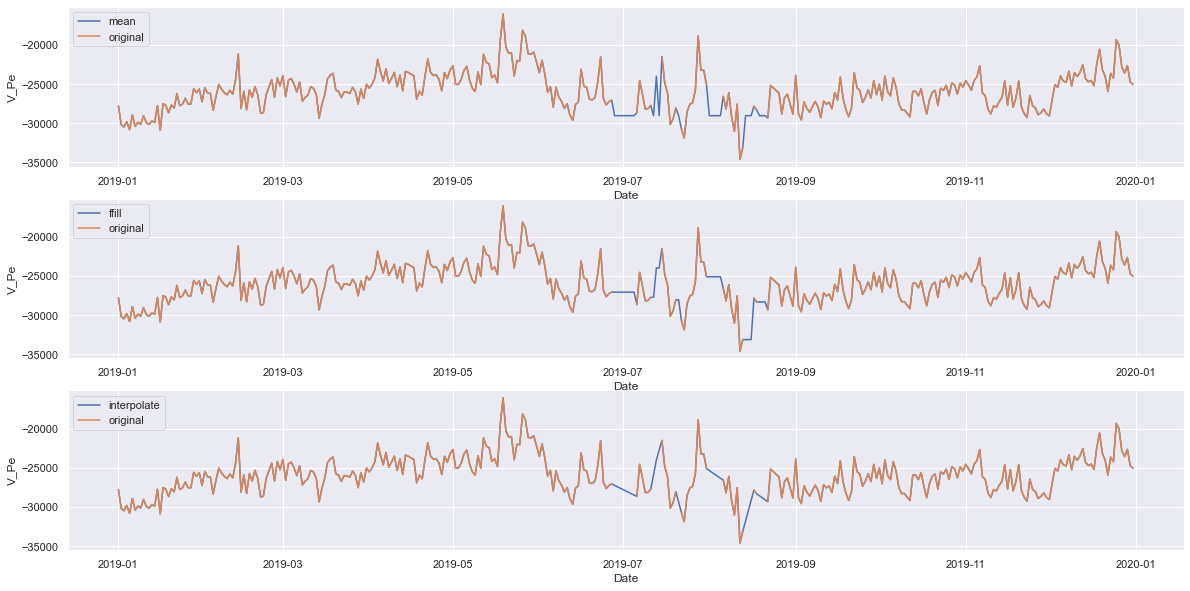

In [205]:
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,10))
subset = df_imputed.loc['2019']

sns.lineplot(x=subset.index, y=subset['V_Pe'].fillna(df['V_Pe'].mean()), label='mean', ax=ax[0])
sns.lineplot(x=subset.index, y=subset['V_Pe'], label='original', ax=ax[0])

sns.lineplot(x=subset.index, y=subset['V_Pe'].ffill(), label='ffill', ax=ax[1])
sns.lineplot(x=subset.index, y=subset['V_Pe'], label='original', ax=ax[1])

sns.lineplot(x=subset.index, y=subset['V_Pe'].interpolate(), label='interpolate', ax=ax[2])
sns.lineplot(x=subset.index, y=subset['V_Pe'], label='original', ax=ax[2])

plt.legend()
plt.show()

#### H_FCP

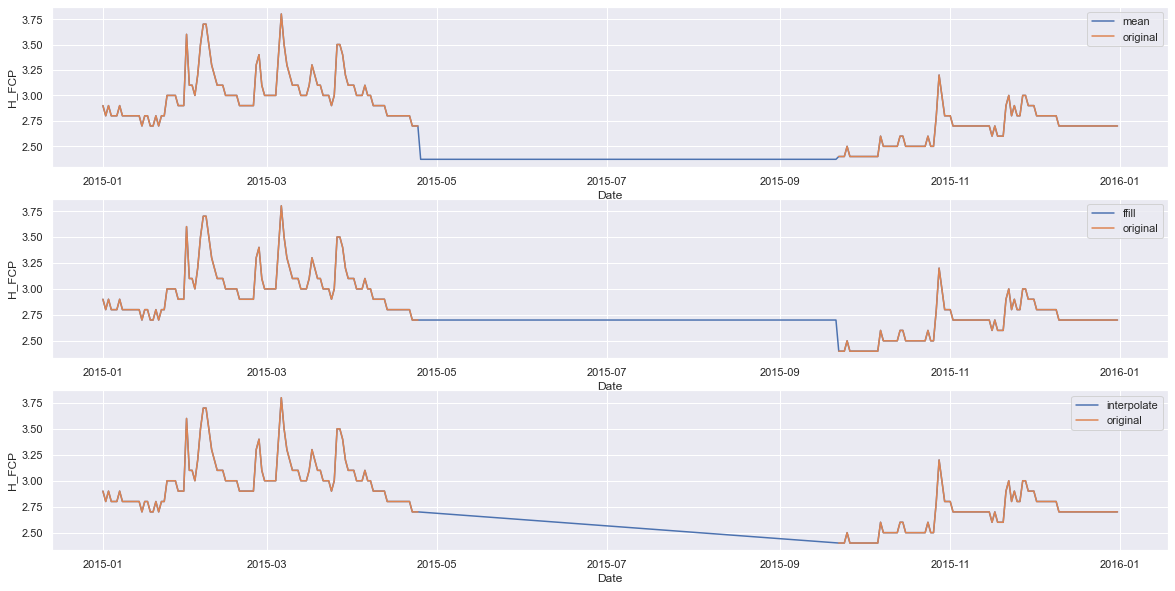

In [206]:
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,10))
subset = df_imputed.loc['2015']

sns.lineplot(x=subset.index, y=subset['H_FCP'].fillna(df['H_FCP'].mean()), label='mean', ax=ax[0])
sns.lineplot(x=subset.index, y=subset['H_FCP'], label='original', ax=ax[0])

sns.lineplot(x=subset.index, y=subset['H_FCP'].ffill(), label='ffill', ax=ax[1])
sns.lineplot(x=subset.index, y=subset['H_FCP'], label='original', ax=ax[1])

sns.lineplot(x=subset.index, y=subset['H_FCP'].interpolate(), label='interpolate', ax=ax[2])
sns.lineplot(x=subset.index, y=subset['H_FCP'], label='original', ax=ax[2])

plt.legend()
plt.show()

#### DtG_P24

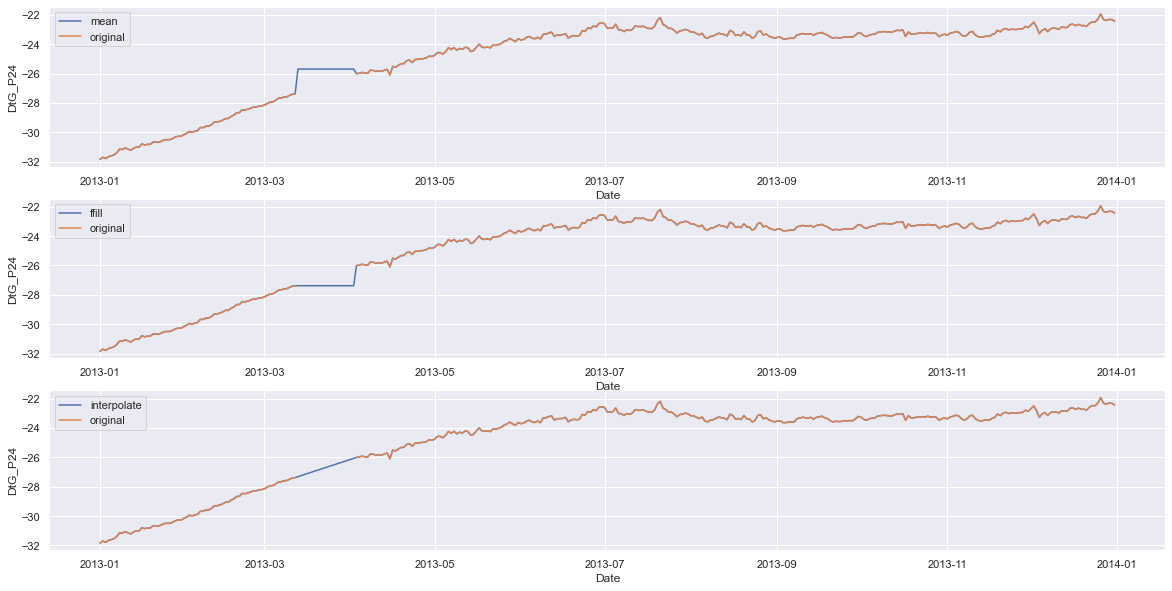

In [207]:
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,10))
subset = df_imputed.loc['2013']

sns.lineplot(x=subset.index, y=subset['DtG_P24'].fillna(df['DtG_P25'].mean()), label='mean', ax=ax[0])
sns.lineplot(x=subset.index, y=subset['DtG_P24'], label='original', ax=ax[0])

sns.lineplot(x=subset.index, y=subset['DtG_P24'].ffill(), label='ffill', ax=ax[1])
sns.lineplot(x=subset.index, y=subset['DtG_P24'], label='original', ax=ax[1])

sns.lineplot(x=subset.index, y=subset['DtG_P24'].interpolate(), label='interpolate', ax=ax[2])
sns.lineplot(x=subset.index, y=subset['DtG_P24'], label='original', ax=ax[2])

plt.legend()
plt.show()

### Impute missing values

In [153]:
df_imputed['T_Pe'] = df['T_Pe'].fillna(df['T_BU'])
df_imputed['V_Pe'] = df_imputed['V_Pe'].interpolate()
df_imputed['H_FCP'] = df_imputed['H_FCP'].interpolate()
df_imputed['DtG_P25'] = df_imputed['DtG_P25'].interpolate()
df_imputed['DtG_P24'] = df_imputed['DtG_P24'].interpolate()

## Check for consistent spacing

In [154]:
(df_imputed.index - df_imputed.index.shift(-1)).value_counts()

1 days    5223
Name: Date, dtype: int64

## Downsampling

In [186]:
col_mean = ['DtG_P25', 'H_FCP', 'V_Pe', 'T_BU']
col_sum = ['Rf_BU']
df_weekly = df_imputed[col_mean].resample('7D').mean()
df_weekly['Rf_BU'] = df_imputed[col_sum].resample('7D').sum()
df_weekly = df_imputed.loc['2009':]

### Decompose features

In [187]:
def decompose_features(series, per):
    results = seasonal_decompose(series, model='additive', period=per, extrapolate_trend='freq')
    f, ax = plt.subplots(nrows=4, ncols=1, figsize=(20,10))
    sns.lineplot(x=series.index, y=results.observed, ax=ax[0])
    sns.lineplot(x=series.index, y=results.trend, ax=ax[1])
    sns.lineplot(x=series.index, y=results.seasonal, ax=ax[2])
    sns.lineplot(x=series.index, y=results.resid, ax=ax[3])
    plt.show()
    
    return results

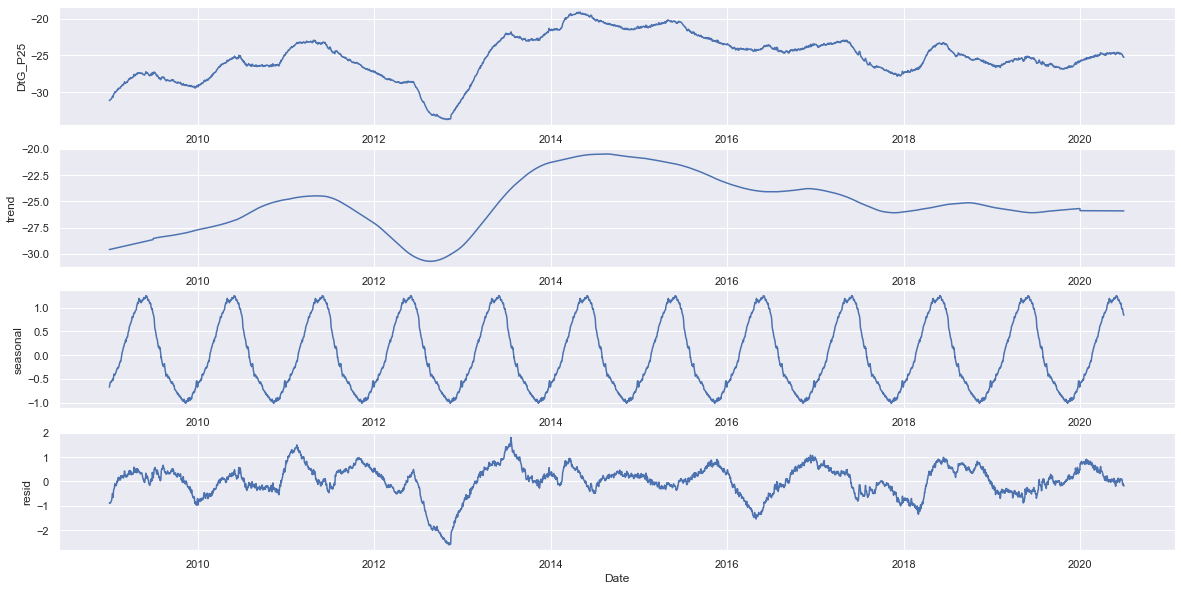

In [193]:
y_decompose = decompose_features(df_weekly['DtG_P25'], 365)

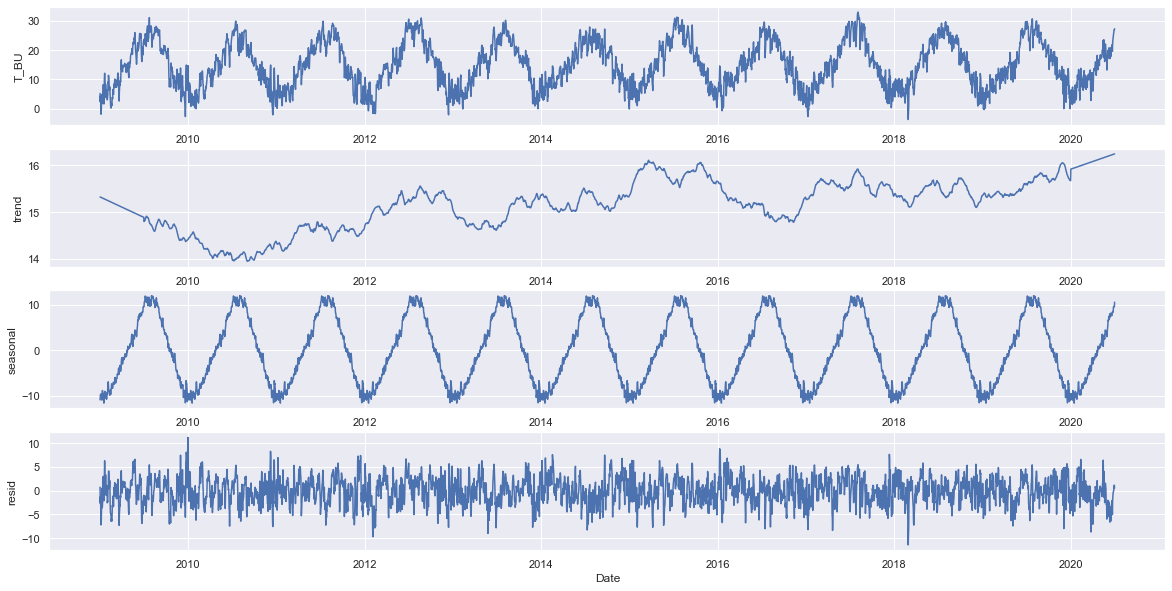

In [194]:
temp = df_weekly['T_BU']
temp_decompose = decompose_features(temp, 365)

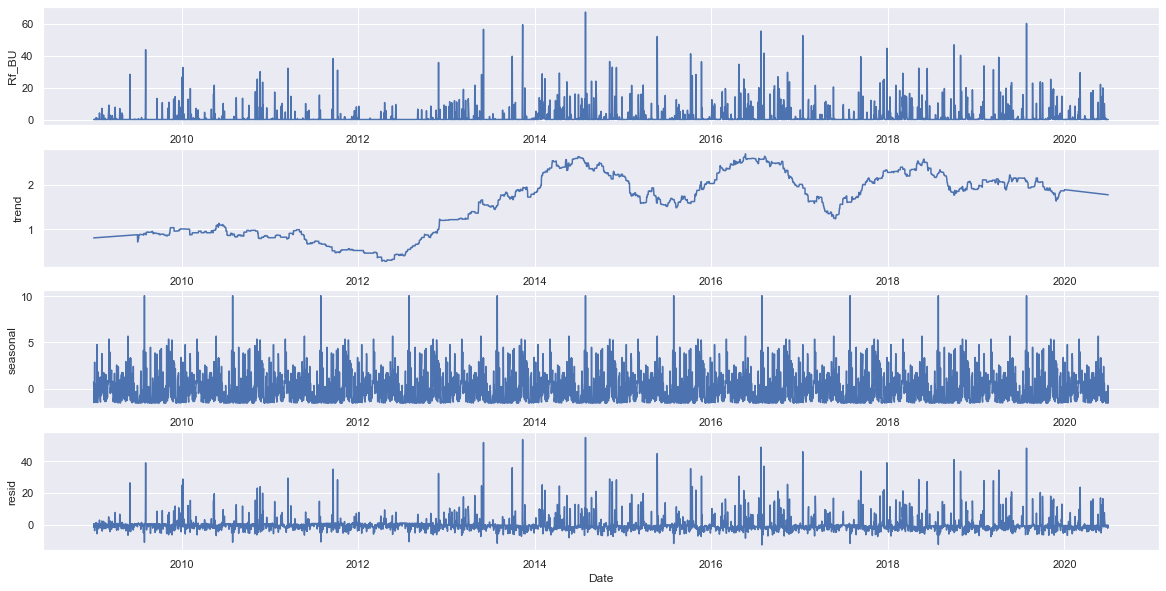

In [195]:
rainfall = df_weekly['Rf_BU']
rainfall_decompose = decompose_features(rainfall, 365)

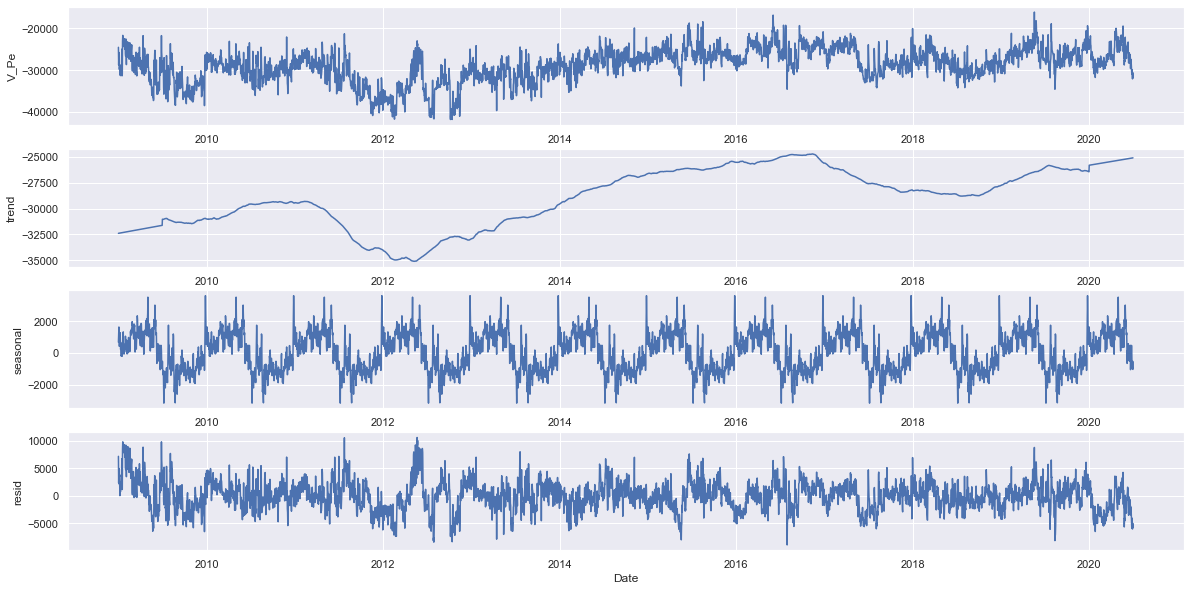

In [196]:
extraction = df_weekly['V_Pe']
extraction_decompose = decompose_features(extraction, 365)

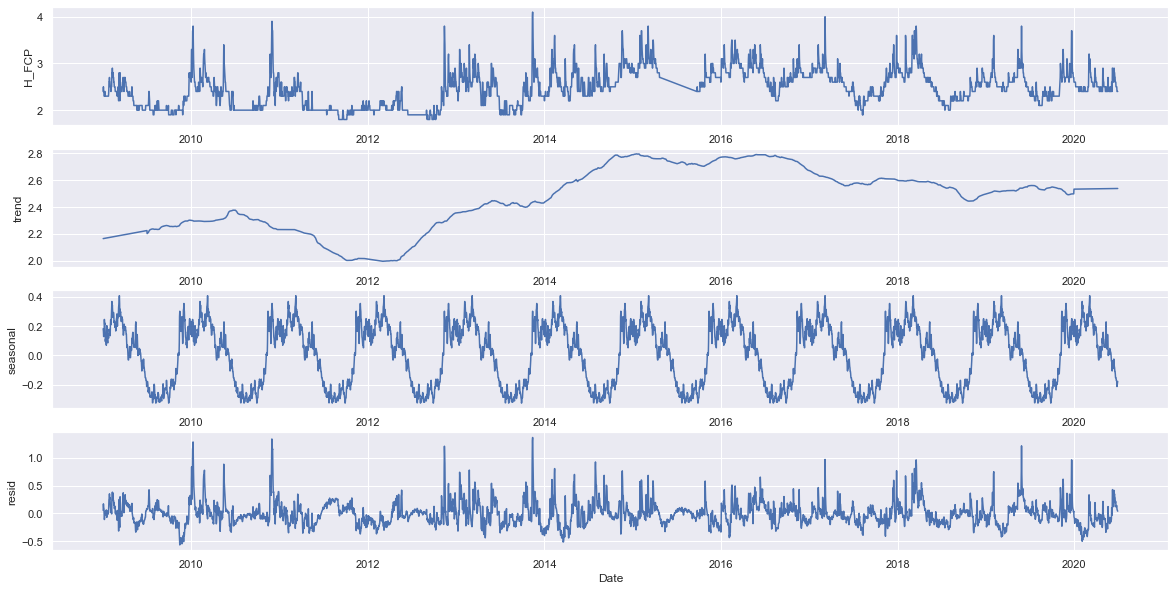

In [197]:
hydrometry = df_weekly['H_FCP']
hydrometry_decompose = decompose_features(hydrometry, 365)

In [198]:
df_decomposed = pd.DataFrame(index=df_weekly.index)
features = [y_decompose, temp_decompose, rainfall_decompose, extraction_decompose, hydrometry_decompose]
for feature in features:
    df_decomposed[f'{feature.observed.name}'] = feature.observed
    df_decomposed[f'{feature.observed.name}_trend'] = feature.trend
    df_decomposed[f'{feature.observed.name}_seasonal'] = feature.seasonal

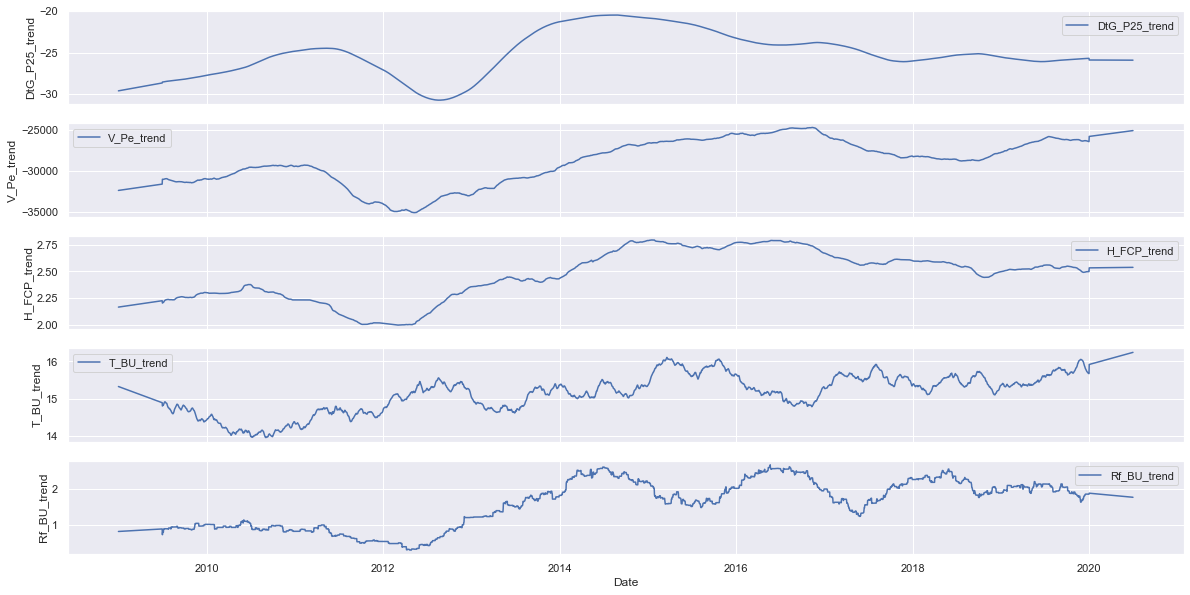

In [199]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(20,10), sharex=True)

sns.lineplot(x=df_decomposed.index, y=df_decomposed['DtG_P25_trend'], label='DtG_P25_trend', ax=ax[0])
sns.lineplot(x=df_decomposed.index, y=df_decomposed['V_Pe_trend'], label='V_Pe_trend', ax=ax[1])
sns.lineplot(x=df_decomposed.index, y=df_decomposed['H_FCP_trend'], label='H_FCP_trend', ax=ax[2])
sns.lineplot(x=df_decomposed.index, y=df_decomposed['T_BU_trend'], label='T_BU_trend', ax=ax[3])
sns.lineplot(x=df_decomposed.index, y=df_decomposed['Rf_BU_trend'], label='Rf_BU_trend', ax=ax[4])

plt.legend()
plt.show()

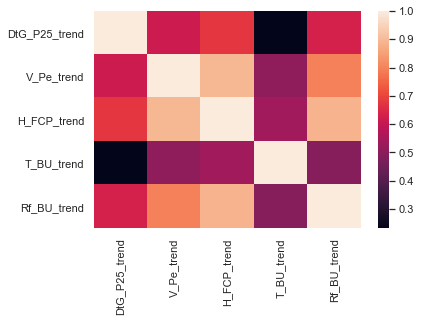

In [200]:
col_trend = ['DtG_P25_trend', 'V_Pe_trend', 'H_FCP_trend', 'T_BU_trend', 'Rf_BU_trend']
corr_trend =  df_decomposed[col_trend].corr()
sns.heatmap(corr_trend)

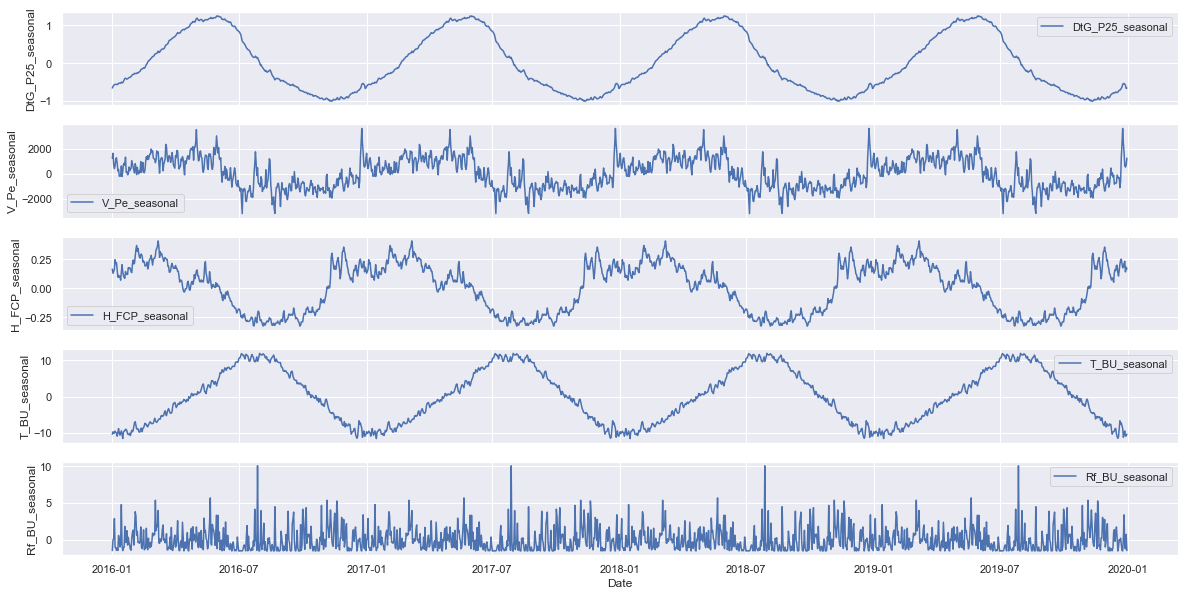

In [201]:
subset_dec = df_decomposed['2016':'2019']

f, ax = plt.subplots(nrows=5, ncols=1, figsize=(20,10), sharex=True)

sns.lineplot(x=subset_dec.index, y=subset_dec['DtG_P25_seasonal'], label='DtG_P25_seasonal', ax=ax[0])
sns.lineplot(x=subset_dec.index, y=subset_dec['V_Pe_seasonal'], label='V_Pe_seasonal', ax=ax[1])
sns.lineplot(x=subset_dec.index, y=subset_dec['H_FCP_seasonal'], label='H_FCP_seasonal', ax=ax[2])
sns.lineplot(x=subset_dec.index, y=subset_dec['T_BU_seasonal'], label='T_BU_seasonal', ax=ax[3])
sns.lineplot(x=subset_dec.index, y=subset_dec['Rf_BU_seasonal'], label='Rf_BU_seasonal', ax=ax[4])

plt.legend()
plt.show()

In [204]:
col_seasonal = ['DtG_P25_seasonal', 'V_Pe_seasonal', 'H_FCP_seasonal', 'T_BU_seasonal', 'Rf_BU_seasonal']
df_decomposed[col_seasonal].groupby(df_decomposed.index.month).agg([np.mean]).round(2)

,DtG_P25_seasonal,V_Pe_seasonal,H_FCP_seasonal,T_BU_seasonal,Rf_BU_seasonal
,mean,mean,mean,mean,mean
Date,,,,,
1,-0.48,512.94,0.15,-9.93,-0.17
2,-0.10,772.80,0.25,-8.19,0.07
3,0.43,1177.43,0.25,-5.01,0.34
4,0.92,1269.66,0.06,-0.96,-0.10
5,1.17,1374.97,0.08,2.49,0.52
6,1.09,142.39,-0.08,7.50,-0.46
7,0.39,-1052.79,-0.25,10.77,-0.40
8,-0.27,-1066.79,-0.29,10.52,-0.58


## Relative feature lags 
- Groundwater Level - Maximum in Mai/June - Minimum in Oktober/November
- Drainage (inversed negative) - Minimum in March/April - Maximum in June-August
- Hydrometry - Maximum in February/March - Minimum in June - August
- Temperatur - Maximum in June-August - Minimum in January/December
- Rainfall - Maximum in November, Minimum in June - August 

- Temperature lags 2 Month behind Groundwater Level
- Drainage lags -1 Month behind Groundwater Level
- Hydrometry lag -3 Month behind Groundwater Level

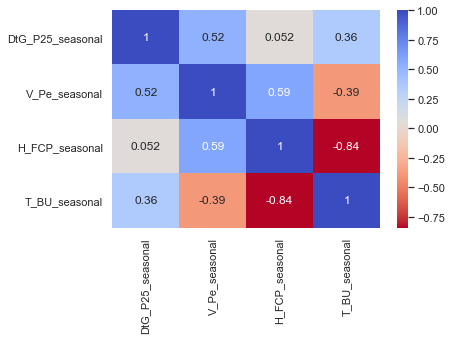

In [211]:
col_seas = ['DtG_P25_seasonal', 'V_Pe_seasonal', 'H_FCP_seasonal', 'T_BU_seasonal']
corr_seas =  df_decomposed[col_seas].corr()
sns.heatmap(corr_seas, cmap='coolwarm_r', annot=True)

In [224]:
df_decomposed['V_Pe_seasonal_1M'] = df_decomposed['V_Pe_seasonal'].shift(1*30)
df_decomposed['H_FCP_seasonal_3M'] = df_decomposed['H_FCP_seasonal'].shift(3*30)
df_decomposed['T_BU_seasonal_2Mr'] = df_decomposed['T_BU_seasonal'].shift(-2*30)

In [221]:
df_decomposed['V_Pe_seasonal']

Date
2009-01-01     669.882968
2009-01-02    1239.231648
2009-01-03    1625.412675
2009-01-04     707.173320
2009-01-05     408.492079
                 ...     
2020-06-26    -794.562785
2020-06-27    -849.927488
2020-06-28   -1000.798909
2020-06-29    -532.593724
2020-06-30   -1040.940313
Freq: D, Name: V_Pe_seasonal, Length: 4199, dtype: float64

In [225]:
col_seasonal = ['DtG_P25_seasonal', 'V_Pe_seasonal_1M', 'H_FCP_seasonal_3M', 'T_BU_seasonal_2Mr']
df_decomposed[col_seasonal].groupby(df_decomposed.index.month).agg([np.mean]).round(2)

,DtG_P25_seasonal,V_Pe_seasonal_1M,H_FCP_seasonal_3M,T_BU_seasonal_2Mr
,mean,mean,mean,mean
Date,,,,
1,-0.48,142.87,-0.18,-4.88
2,-0.10,481.82,0.15,-0.99
3,0.43,784.04,0.17,2.39
4,0.92,1171.28,0.15,7.30
5,1.17,1315.76,0.25,10.71
6,1.09,1330.84,0.25,10.63
7,0.39,125.62,0.06,5.97
8,-0.27,-1054.41,0.07,0.56


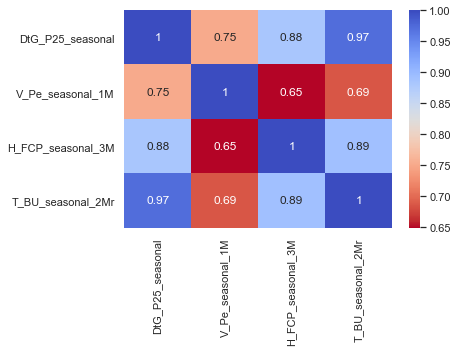

In [226]:
col_seas = ['DtG_P25_seasonal', 'V_Pe_seasonal_1M', 'H_FCP_seasonal_3M', 'T_BU_seasonal_2Mr']
corr_seas =  df_decomposed[col_seas].corr()
sns.heatmap(corr_seas, cmap='coolwarm_r', annot=True)

## Manual decompose

In [94]:
def ma_decompose(series, window_trend, window_seasonality):
    trend = series.rolling(window_trend).mean()
    seasonality = (series - trend).rolling(window_seasonality, center=True).mean()
    residual = series - trend - seasonality
    
    return trend, seasonality, residual 

In [95]:
def plot_decomposition(series, trend, seasonality, residual):
    f, ax = plt.subplots(nrows=4, ncols=1, sharex=True, figsize = (20,10))
    ax[0].plot(series)
    ax[0].set_ylim([series.min(), series.max()])
    ax[0].set_ylabel = 'Observed'
    ax[1].plot(trend)
    ax[1].set_ylim([series.min(), series.max()])
    ax[1].set_ylabel = 'Trend'
    ax[2].plot(seasonality)
    ax[2].set_ylabel = 'Seasonality'
    ax[3].plot(residual)
    ax[3].set_ylabel = 'Residual'
    #plt.title(series.name)
    plt.show()

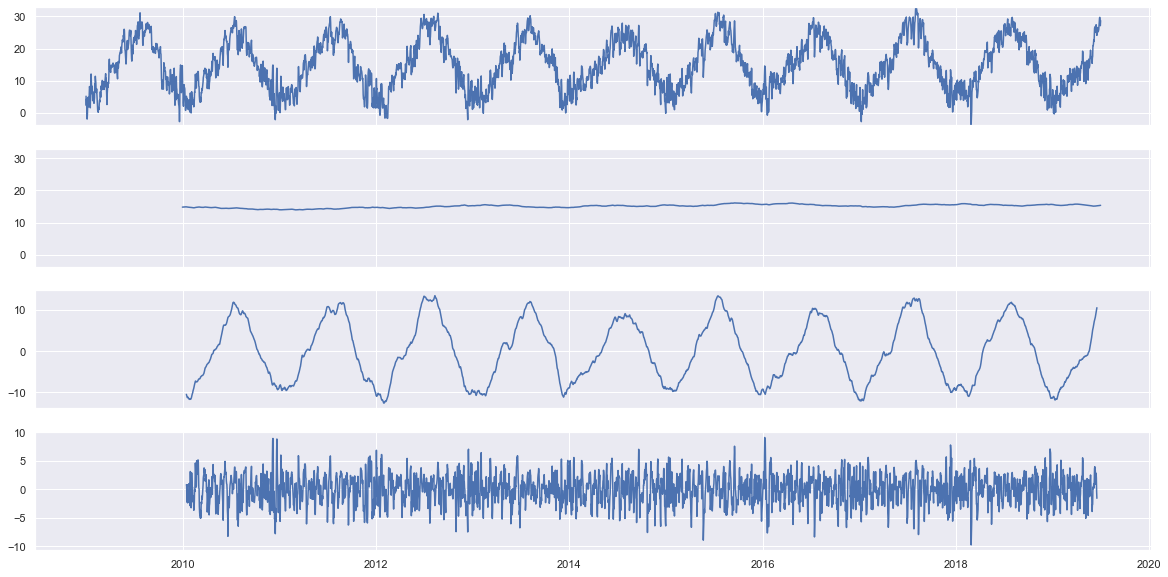

In [96]:
dec_series = train.loc['2009-01-01':,'T_BU']
trend, seasonality, residual = ma_decompose(dec_series, 365, 30)
plot_decomposition(dec_series, trend, seasonality, residual)

## Train-Test-Split

In [227]:
# Train-Test-Split

train = df_decomposed[:-365]
y_train = train['DtG_P25']
test = df_decomposed[-365:]
y_test = test['DtG_P25']

## Baseline Model

### Mean

In [228]:
def RSME(y_pred, y_true):
    return np.sqrt(np.mean((y_true - y_pred)**2)).round(2)

In [229]:
y_train = train['DtG_P25']
y_pred_mean = pd.Series(y_train.mean(), index=test.index)

In [230]:
print(f'R2 score of mean prediction is: {round(r2_score(y_test, y_pred_mean),3)}')
print(f'RSME of mean prediction is: {RSME(y_test, y_pred_mean)}')

R2 score of mean prediction is: -0.565
RSME of mean prediction is: 0.92


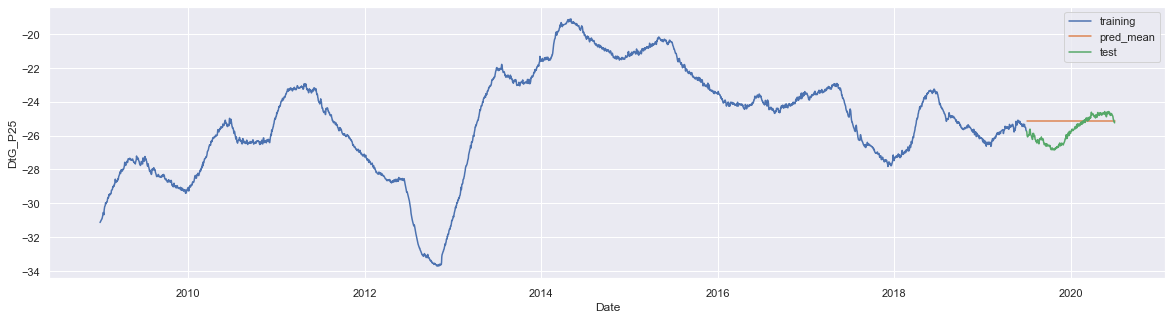

In [231]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
sns.lineplot(x = y_train.index, y=y_train, label='training')
sns.lineplot(x = test.index, y=y_pred_mean, label='pred_mean')
sns.lineplot(x = test.index, y=y_test, label='test')

### Naive Approach

In [239]:
y_pred_naive = pd.Series(y_train[-1], index=test.index)

In [240]:
print(f'R2 score of mean prediction is: {round(r2_score(y_test, y_pred_naive),3)}')
print(f'RSME of mean prediction is: {RSME(y_test, y_pred_naive)}')

R2 score of mean prediction is: -0.004
RSME of mean prediction is: 0.74


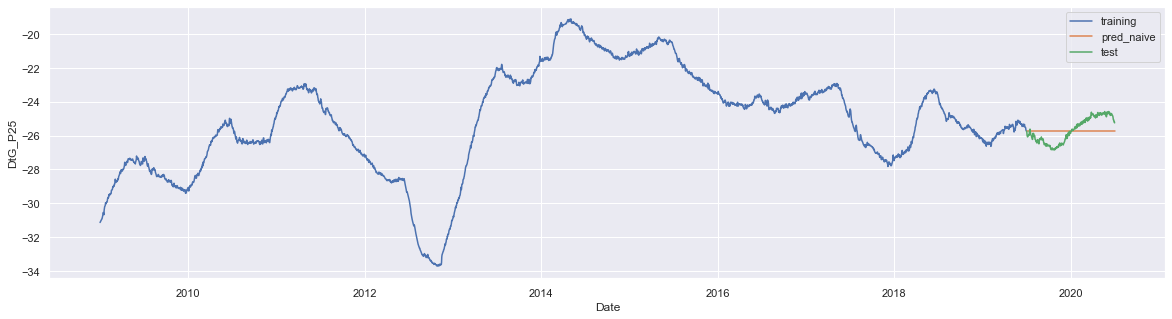

In [242]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
sns.lineplot(x = y_train.index, y=y_train, label='training')
sns.lineplot(x = test.index, y=y_pred_naive, label='pred_naive')
sns.lineplot(x = test.index, y=y_test, label='test')

### General Trend

In [232]:
X_train_gen = pd.DataFrame(range(len(y_train)), index = y_train.index, columns= ['general_trend'])
X_test_gen = pd.DataFrame(range(len(y_test)), index = y_test.index, columns= ['general_trend'])
baseline_trend = LinearRegression()
baseline_trend.fit(X_train_gen, y_train)
y_pred_trend = baseline_trend.predict(X_test_gen)

In [233]:
print(f'R2 score of mean prediction is: {round(r2_score(y_test, y_pred_trend),3)}')
print(f'RSME of mean prediction is: {RSME(y_test, y_pred_trend)}')

R2 score of mean prediction is: -2.007
RSME of mean prediction is: 1.28


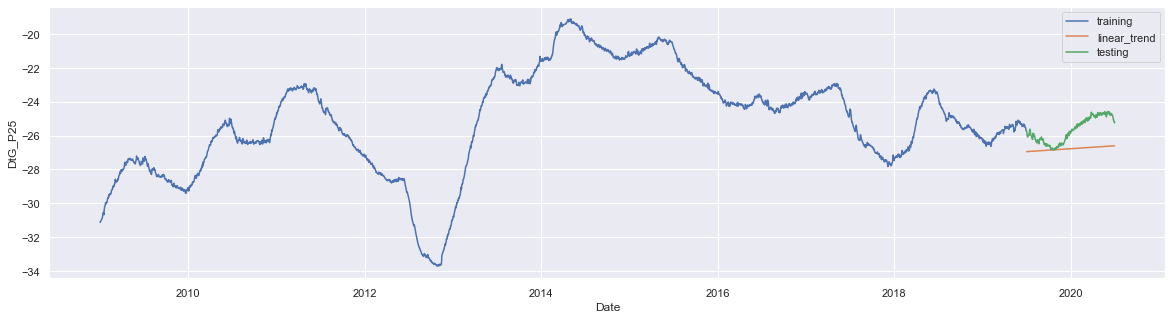

In [234]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
sns.lineplot(x = y_train.index, y=y_train, label='training')
sns.lineplot(x = y_test.index, y=y_pred_trend, label='linear_trend')
sns.lineplot(x = y_test.index, y=y_test, label='testing')

### Seasonal

In [18]:
X_train_seas = pd.DataFrame(pd.get_dummies(y_train.index.month)).set_index(y_train.index)
X_test_seas = pd.DataFrame(pd.get_dummies(y_test.index.month)).set_index(y_test.index)
baseline_seas = LinearRegression()
baseline_seas.fit(X_train_seas, y_train)
y_pred_seas = baseline_seas.predict(X_test_seas)

In [19]:
print(f'R2 score of mean prediction is: {round(r2_score(y_test, y_pred_seas),3)}')
print(f'RSME of mean prediction is: {RSME(y_test, y_pred_seas)}')

R2 score of mean prediction is: 0.61
RSME of mean prediction is: 0.46


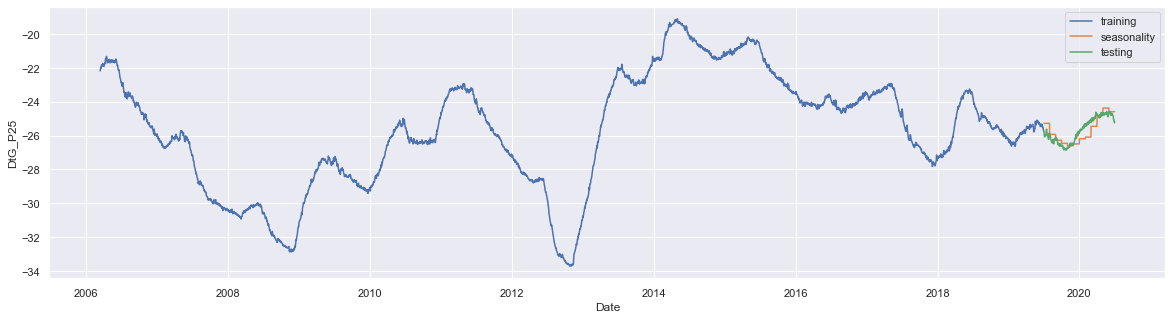

In [219]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
sns.lineplot(x = y_train.index, y=y_train, label='training')
sns.lineplot(x = y_test.index, y=y_pred_seas, label='seasonality')
sns.lineplot(x = y_test.index, y=y_test, label='testing')